In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data

In [2]:
proj_path = '/data100t1/home/wanying/CCHC/proteomics/20241014_data_cleaning/output'
id_mapping_fn = f'{proj_path}/olink_uniprot_assay_id_mapping.csv'
df_id_mapping = pd.read_csv(id_mapping_fn)
display(df_id_mapping.head(2))

protein_fn = f'{proj_path}/20240919_CCHC_proteomics.batch2.OlinkID.NPX.csv'
df_protein = pd.read_csv(protein_fn)
display(df_protein.head(2))

pheno_fn = '/data100t1/share/CCHC/phenotypes/0724/cchc_phenotypes_0724.txt'
cols = ['RRID', 'LABID', 'AGE_AT_VISIT', 'GENDER']
df_pheno = pd.read_csv(pheno_fn, sep='|', dtype=str)[cols]
for col in ['AGE_AT_VISIT', 'GENDER']:
    df_pheno[col] = pd.to_numeric(df_pheno[col], errors='coerce')
display(df_pheno.head(2))

# Merge phenotype with df_protein
df_protein_merge = df_pheno.merge(df_protein, on='LABID')
display(df_protein_merge.head(2))

,OlinkID,UniProt,Assay
0,OID45511,EXT1,Extension control 1
1,OID45519,INC1,Incubation control 1


,LABID,OID45511,OID45519,OID45503,OID40001,OID40002,OID40003,OID40004,OID40005,OID40006,...,OID45493,OID45494,OID45495,OID45496,OID45497,OID45498,OID45499,OID45500,OID45501,OID45502
0,10Y0001,0.0,0.098128,0.009231,1.719527,1.415027,-0.662254,1.242358,-0.145884,-4.228008,...,-0.187204,-0.333129,-0.048588,0.351591,0.072964,0.038539,0.112379,-0.363623,-0.330237,-0.060775
1,10Y0005,0.0,0.084841,0.118812,1.020391,1.059447,-0.461474,-0.099768,-0.672721,2.240973,...,0.214983,0.129681,0.060721,0.019057,0.313470,0.118445,0.091292,0.262861,-0.013622,-0.174585


,RRID,LABID,AGE_AT_VISIT,GENDER
0,BD0001,BD4001,40.0,2.0
1,BD0001,5Y0002,30.4,2.0


,RRID,LABID,AGE_AT_VISIT,GENDER,OID45511,OID45519,OID45503,OID40001,OID40002,OID40003,...,OID45493,OID45494,OID45495,OID45496,OID45497,OID45498,OID45499,OID45500,OID45501,OID45502
0,BD0005,15Y0055,51.1,1.0,0.0,0.078425,0.058952,1.095446,0.196774,4.525359,...,0.002698,0.082991,0.430357,0.036555,0.015324,0.228875,0.512836,0.211335,0.814661,-0.522716
1,BD0009,15Y0224,61.2,1.0,0.0,-0.047388,0.016086,3.353032,1.195139,6.889091,...,-0.197254,-0.164190,-0.001129,-0.054188,0.064943,0.147697,0.199649,0.220925,0.343605,0.068846


In [3]:
# Load original parquet file
fn = '/data100t1/share/CCHC/CCHC_proteomics_batch2/McCormick_Below_North_Shah_Freedman_NPX_2024-09-19.parquet'
df_data = pd.read_parquet(fn)
output_fn = 'McCormick_Below_North_Shah_Freedman_NPX_2024-09-19.csv'

display(df_data.head(2))

,SampleID,SampleType,WellID,PlateID,DataAnalysisRefID,OlinkID,UniProt,Assay,AssayType,Panel,Block,Count,ExtNPX,NPX,Normalization,PCNormalizedNPX,AssayQC,SampleQC,ExploreVersion
0,10Y0033,SAMPLE,A1,Piper_Joe_Rack_1_(15)_for_NPX,D10001,OID45511,EXT1,Extension control 1,ext_ctrl,Explore_HT,1,4504,0.0,0.0,Intensity,0.0,NA,PASS,6.7.2
1,5Y0629,SAMPLE,A2,Piper_Joe_Rack_1_(15)_for_NPX,D10001,OID45511,EXT1,Extension control 1,ext_ctrl,Explore_HT,1,6442,0.0,0.0,Intensity,0.0,NA,PASS,6.7.2


In [8]:
# Check what are in AssayQC and SampleQC
for col in ['AssayQC', 'SampleQC']:
    print(f'\n# ########## {col} value counts ##########')
    print(df_data[col].value_counts())
    print('# Missing or failed')
    if col == 'AssayQC':
        print(df_data[df_data[col]=='NA']['SampleID'].unique())
        print('# Number of unique samples:', len(df_data[df_data[col]=='NA']['SampleID'].unique()))
    else:
        print(df_data[df_data[col]=='FAIL']['SampleID'].unique())
        print('# Number of unique samples:', len(df_data[df_data[col]=='FAIL']['SampleID'].unique()))


# ########## AssayQC value counts ##########
AssayQC
PASS    7281600
NA        32256
WARN       2880
Name: count, dtype: int64
# Missing or failed
['10Y0033' '5Y0629' 'BA0150' ... 'BL0286' 'BL0299' 'BL0158']
# Number of unique samples: 1214

# ########## SampleQC value counts ##########
SampleQC
PASS    7314938
FAIL       1661
WARN        137
Name: count, dtype: int64
# Missing or failed
['SC1' 'PC1' 'NC1']
# Number of unique samples: 3


In [222]:
# Remove controls
# Drop control samples (10 controls)
controls = [f'SC{i+1}' for i in range(3)] + [f'PC{i+1}' for i in range(5)] + [f'NC{i+1}' for i in range(2)]
df_data_no_control = df_data[~df_data['SampleID'].isin(controls)]
print(df_data_no_control.shape)

# Drop protein controls: Incubation Control, Extension Control, Amplification control
lst_control_proteins = []
for val in df_data_no_control['Assay']:
    if 'control' in val.lower():
        lst_control_proteins.append(val)
lst_control_proteins = list(set(lst_control_proteins))
print(lst_control_proteins)
df_data_no_control = df_data_no_control[~df_data_no_control['Assay'].isin(lst_control_proteins)]
print(df_data_no_control.shape)

output_fn = '/data100t1/home/wanying/CCHC/proteomics/20241014_data_cleaning/output/20240919_CCHC_proteomics.batch2.control_reomved.all.csv'
df_data_no_control.to_csv(output_fn, index=False)

(6554576, 19)
['Incubation\xa0control\xa08', 'Incubation\xa0control\xa05', 'Incubation\xa0control\xa03', 'Extension\xa0control\xa02', 'Incubation\xa0control\xa07', 'Incubation\xa0control\xa02', 'Extension\xa0control\xa08', 'Amplification\xa0control\xa08', 'Extension\xa0control\xa07', 'Amplification\xa0control\xa04', 'Amplification\xa0control\xa01', 'Extension\xa0control\xa03', 'Amplification\xa0control\xa03', 'Incubation\xa0control\xa06', 'Amplification\xa0control\xa02', 'Amplification\xa0control\xa05', 'Incubation\xa0control\xa04', 'Extension\xa0control\xa01', 'Amplification\xa0control\xa06', 'Amplification\xa0control\xa07', 'Incubation\xa0control\xa01', 'Extension\xa0control\xa04', 'Extension\xa0control\xa05', 'Extension\xa0control\xa06']
(6525680, 19)


In [209]:
print(df_data_no_control['AssayQC'].value_counts())
print(df_data_no_control['SampleQC'].value_counts())

AssayQC
PASS    6523100
WARN       2580
Name: count, dtype: int64
SampleQC
PASS    6525546
WARN        134
Name: count, dtype: int64


In [224]:
df_data_no_control['AssayType'].value_counts()

AssayType
assay    6525680
Name: count, dtype: int64

# 2. Count missingness
The original plan is to filter by AssayQC (NA, PASS, WARN). However, control proteins have been identified.

After removal of control proteins, AssayQC and SampleQC only have "PASS" and "WARN". AssayType only has value "Asssay"

## 2.1 Missingness by protein

# Processed 5420    
# DONE
# ########## AssayQC=NA ##########
missingness
0.000000    5408
0.071429       8
0.142857       2
0.285714       1
1.000000       1
Name: count, dtype: int64


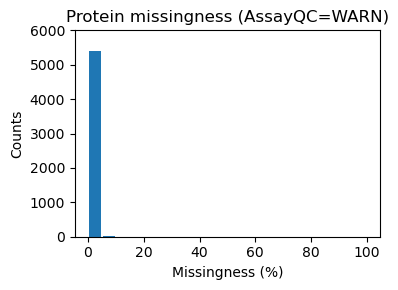

In [212]:
# Calcualte missingsess, AssayQC=WARN
missingness_freqs = [] # Store missingness frequecies
proteins = []
for i, (protein, df) in enumerate(df_data_no_control.groupby('OlinkID')):
    proteins.append(protein)
    missingness_freqs.append(len(df[df['AssayQC']=='WARN'])/len(df))
    if i%10==0: print(f'\r# Processed {i+1}    ', end='', flush=True)
print(f'\r# Processed {i+1}    ')
print(f'# DONE')

df_protein_missingness_freq = pd.DataFrame({'OlinkID':proteins, 'missingness':missingness_freqs})
output_fn = '/data100t1/home/wanying/CCHC/proteomics/20241014_data_cleaning/output/missingness_protein.AssayQC_warn.txt'
df_protein_missingness_freq.to_csv(output_fn, sep='\t', index=False)

print('# ########## AssayQC=NA ##########')
print(df_protein_missingness_freq['missingness'].value_counts())

# Plot missingnsess
fig, ax = plt.subplots(figsize=(4,3))
nbins = 20
ax.hist(df_protein_missingness_freq_na['missingness']*100, rwidth=0.9, bins=nbins)
ax.set_xlabel('Missingness (%)')
ax.set_ylabel('Counts')
ax.set_title('Protein missingness (AssayQC=WARN)')
ax.set_ylim(top=6000)

fig.tight_layout()

In [213]:
# # Calcualte missingsess, AssayQC=NA or WARN
# missingness_freqs = [] # Store missingness frequecies
# proteins = []
# for i, (protein, df) in enumerate(df_data_no_control.groupby('OlinkID')):
#     proteins.append(protein)
#     missingness_freqs.append(len(df[df['AssayQC']!='PASS'])/len(df))
#     if i%10==0: print(f'\r# Processed {i+1}    ', end='', flush=True)
# print(f'\r# Processed {i+1}    ')
# print(f'# DONE')

# df_protein_missingness_freq_na_or_warn = pd.DataFrame({'OlinkID':proteins, 'missingness':missingness_freqs})
# output_fn = '/data100t1/home/wanying/CCHC/proteomics/20241014_data_cleaning/output/missingness_protein.AssayQC_NA_or_WARN.txt'
# df_protein_missingness_freq_na_or_warn.to_csv(output_fn, sep='\t', index=False)

# print('# ########## AssayQC=NA ##########')
# print(df_protein_missingness_freq_na['missingness'].value_counts())
# print('# ########## AssayQC=NA or WARN ##########')
# print(df_protein_missingness_freq_na_or_warn['missingness'].value_counts())

# # Plot missingnsess
# fig, ax = plt.subplots(ncols=2, figsize=(8,3))
# nbins = 20
# ax[0].hist(df_protein_missingness_freq_na['missingness']*100, rwidth=0.9, bins=nbins)
# ax[0].set_xlabel('Missingness (%)')
# ax[0].set_ylabel('Counts')
# ax[0].set_title('Protein missingness (AssayQC=NA)')
# ax[0].set_ylim(top=6000)
# ax[0].annotate(text='5420', xy=(0.01,5450))
# ax[0].annotate(text='24', xy=(92,100))

# ax[1].hist(df_protein_missingness_freq_na_or_warn['missingness']*100, rwidth=0.9, bins=nbins)
# ax[1].set_xlabel('Missingness (%)')
# ax[1].set_ylabel('Counts')
# ax[1].set_title('Protein missingness (AssayQC=NA or WARN)')
# ax[1].set_ylim(top=6000)
# ax[1].annotate(text='5408', xy=(0,5450))
# ax[1].annotate(text='8', xy=(6,78))
# ax[1].annotate(text='2', xy=(13,72))
# ax[1].annotate(text='25', xy=(95,100))

# fig.tight_layout()

## 2.2 Missingness by sample

# Processed 1204    
# DONE
# ########## AssayQC=NA ##########
missingness
0.000185    688
0.000369    258
0.000554    172
0.001845     86
Name: count, dtype: int64


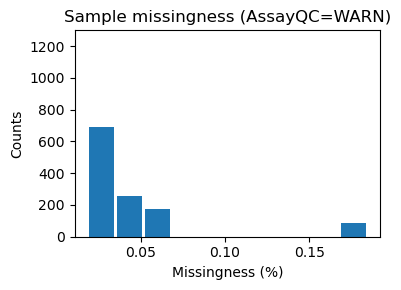

In [215]:
# Calcualte missingsess by AssayQC=NA
missingness_freqs = [] # Store missingness frequecies
samples = []
for i, (sample, df) in enumerate(df_data_no_control.groupby('SampleID')):
    samples.append(sample)
    missingness_freqs.append(len(df[df['AssayQC']=='WARN'])/len(df))
    if i%10==0: print(f'\r# Processed {i+1}    ', end='', flush=True)
print(f'\r# Processed {i+1}    ')
print(f'# DONE')

df_sample_missingness_freq = pd.DataFrame({'LABID':samples, 'missingness':missingness_freqs})
output_fn = '/data100t1/home/wanying/CCHC/proteomics/20241014_data_cleaning/output/missingness_sample.AssayQC_warn.txt'
df_sample_missingness_freq.to_csv(output_fn, sep='\t', index=False)

print('# ########## AssayQC=NA ##########')
print(df_sample_missingness_freq['missingness'].value_counts())

# Plot missingnsess
fig, ax = plt.subplots(figsize=(4,3))

ax.hist(df_sample_missingness_freq['missingness']*100, rwidth=0.9)
ax.set_xlabel('Missingness (%)')
ax.set_ylabel('Counts')
ax.set_title('Sample missingness (AssayQC=WARN)')
ax.set_ylim(top=1300)
ax.annotate(text='1204', xy=(0.435,1220))

fig.tight_layout()

In [94]:
# # Calcualte missingsess by AssayQC=NA or WARN
# missingness_freqs = [] # Store missingness frequecies
# samples = []
# for i, (sample, df) in enumerate(df_data_no_control.groupby('SampleID')):
#     samples.append(sample)
#     missingness_freqs.append(len(df[df['AssayQC']!='PASS'])/len(df))
#     if i%10==0: print(f'\r# Processed {i+1}    ', end='', flush=True)
# print(f'\r# Processed {i+1}    ')
# print(f'# DONE')

# df_sample_missingness_freq_na_or_warn = pd.DataFrame({'LABID':samples, 'missingness':missingness_freqs})
# output_fn = '/data100t1/home/wanying/CCHC/proteomics/20241014_data_cleaning/output/missingness_sample.AssayQC_NA_or_WARN.txt'
# df_sample_missingness_freq_na_or_warn.to_csv(output_fn, sep='\t', index=False)

# print('# ########## AssayQC=NA ##########')
# print(df_sample_missingness_freq_na['missingness'].value_counts())
# print('# ########## AssayQC=NA or WARN ##########')
# print(df_sample_missingness_freq_na_or_warn['missingness'].value_counts())
# # Plot missingnsess
# fig, ax = plt.subplots(ncols=2, figsize=(8,3))

# ax[0].hist(df_sample_missingness_freq['missingness']*100, rwidth=0.9)
# ax[0].set_xlabel('Missingness (%)')
# ax[0].set_ylabel('Counts')
# ax[0].set_title('Sample missingness (AssayQC=NA)')
# ax[0].set_ylim(top=1300)
# ax[0].annotate(text='1204', xy=(0.435,1220))

# ax[1].hist(df_sample_missingness_freq_na_or_warn['missingness']*100, rwidth=0.9)
# ax[1].set_xlabel('Missingness (%)')
# ax[1].set_ylabel('Counts')
# ax[1].set_title('Sample missingness (AssayQC=NA or WARN)')
# ax[1].set_ylim(top=1300)
# ax[1].annotate(text='688', xy=(0.461,710))
# ax[1].annotate(text='258', xy=(0.477,280))
# ax[1].annotate(text='172', xy=(0.493,190))
# ax[1].annotate(text='86', xy=(0.611,100))

# fig.tight_layout()

# Processed 1204    
# DONE


# 3. Which proteins are missing in all samples (by AssayQC)

In [176]:
mask = df_data_no_control['AssayQC'] == 'NA'
missing_proteins = set([str(v) for v in df_data_no_control[mask]['Assay'].unique()])
missing_proteins

{'Amplification\xa0control\xa01',
 'Amplification\xa0control\xa02',
 'Amplification\xa0control\xa03',
 'Amplification\xa0control\xa04',
 'Amplification\xa0control\xa05',
 'Amplification\xa0control\xa06',
 'Amplification\xa0control\xa07',
 'Amplification\xa0control\xa08',
 'Extension\xa0control\xa01',
 'Extension\xa0control\xa02',
 'Extension\xa0control\xa03',
 'Extension\xa0control\xa04',
 'Extension\xa0control\xa05',
 'Extension\xa0control\xa06',
 'Extension\xa0control\xa07',
 'Extension\xa0control\xa08',
 'Incubation\xa0control\xa01',
 'Incubation\xa0control\xa02',
 'Incubation\xa0control\xa03',
 'Incubation\xa0control\xa04',
 'Incubation\xa0control\xa05',
 'Incubation\xa0control\xa06',
 'Incubation\xa0control\xa07',
 'Incubation\xa0control\xa08'}

In [221]:
df_protein_missingness_freq[df_protein_missingness_freq['missingness']>0].merge(df_id_mapping,on='OlinkID').sort_values('missingness')

,OlinkID,missingness,UniProt,Assay
3,OID45037,0.071429,P20160,AZU1
6,OID45225,0.071429,P14555,PLA2G2A
5,OID45220,0.071429,P19957,PI3
4,OID45061,0.071429,P13987,CD59
7,OID45238,0.071429,P24158,PRTN3
10,OID45262,0.071429,P55000,SLURP1
9,OID45249,0.071429,Q6UWP8,SBSN
8,OID45239,0.071429,P07602,PSAP
1,OID44658,0.142857,Q96RU3,FNBP1
2,OID45034,0.142857,P05067,APP


['Incubation\xa0control\xa08',
 'Incubation\xa0control\xa05',
 'Incubation\xa0control\xa03',
 'Extension\xa0control\xa02',
 'Incubation\xa0control\xa07',
 'Incubation\xa0control\xa02',
 'Extension\xa0control\xa08',
 'Amplification\xa0control\xa08',
 'Extension\xa0control\xa07',
 'Amplification\xa0control\xa04',
 'Amplification\xa0control\xa01',
 'Extension\xa0control\xa03',
 'Amplification\xa0control\xa03',
 'Incubation\xa0control\xa06',
 'Amplification\xa0control\xa02',
 'Amplification\xa0control\xa05',
 'Incubation\xa0control\xa04',
 'Extension\xa0control\xa01',
 'Amplification\xa0control\xa06',
 'Amplification\xa0control\xa07',
 'Incubation\xa0control\xa01',
 'Extension\xa0control\xa04',
 'Extension\xa0control\xa05',
 'Extension\xa0control\xa06']

In [199]:
df_data_no_control.shape

(6554576, 19)

In [205]:
df_data_no_control.shape

(6525680, 19)